# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment

from tqdm.notebook import tqdm
tqdm.pandas()

from autots import AutoTS


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/Train.csv')
data = data.drop(columns=['Item_Identifier'])
# data = data.drop_duplicates().dropna()
data = data.reset_index(drop=True)
data

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


# 3. Initial Analysis

### 3.1. Metadata

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float32
 1   Item_Fat_Content           8523 non-null   int8   
 2   Item_Visibility            8523 non-null   float32
 3   Item_Type                  8523 non-null   int8   
 4   Item_MRP                   8523 non-null   float32
 5   Outlet_Identifier          8523 non-null   int8   
 6   Outlet_Establishment_Year  8523 non-null   int16  
 7   Outlet_Size                8523 non-null   int8   
 8   Outlet_Location_Type       8523 non-null   int8   
 9   Outlet_Type                8523 non-null   int8   
 10  Item_Outlet_Sales          8523 non-null   float32
dtypes: float32(4), int16(1), int8(6)
memory usage: 199.9 KB


In [110]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [14]:
print(f'Number of null data       : {data.isnull().sum().sum()}')
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of null data       : 0
Number of duplicates data : 0


In [13]:
data.nunique()

Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

### 3.2. Columns Processing

In [20]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']
Categorical Columns : []


In [15]:
def replace_missing_values(data):
    for column in numerical_columns:
        data[column] = data[column].fillna(data[column].mean())
    for column in categorical_columns:
        data[column] = data[column].fillna(data[column].mode()[0])

replace_missing_values(data)

In [22]:
def downcasting_dtypes(data):
    fcols = data.select_dtypes('float').columns
    icols = data.select_dtypes('integer').columns

    data[fcols] = data[fcols].apply(pd.to_numeric, downcast='float')
    data[icols] = data[icols].apply(pd.to_numeric, downcast='integer')

downcasting_dtypes(data)

In [19]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()
    for column in categorical_columns:
        data[column] = LE.fit_transform(data[column].astype(str))
        # data[column] = data[column].apply(pd.to_numeric, downcast='integer')
        print(f'{column} : {LE.classes_}') 

change_columns_to_numerical(data)

Item_Fat_Content : ['LF' 'Low Fat' 'Regular' 'low fat' 'reg']
Item_Type : ['Baking Goods' 'Breads' 'Breakfast' 'Canned' 'Dairy' 'Frozen Foods'
 'Fruits and Vegetables' 'Hard Drinks' 'Health and Hygiene' 'Household'
 'Meat' 'Others' 'Seafood' 'Snack Foods' 'Soft Drinks' 'Starchy Foods']
Outlet_Identifier : ['OUT010' 'OUT013' 'OUT017' 'OUT018' 'OUT019' 'OUT027' 'OUT035' 'OUT045'
 'OUT046' 'OUT049']
Outlet_Size : ['High' 'Medium' 'Small']
Outlet_Location_Type : ['Tier 1' 'Tier 2' 'Tier 3']
Outlet_Type : ['Grocery Store' 'Supermarket Type1' 'Supermarket Type2'
 'Supermarket Type3']


### 3.3. EDA

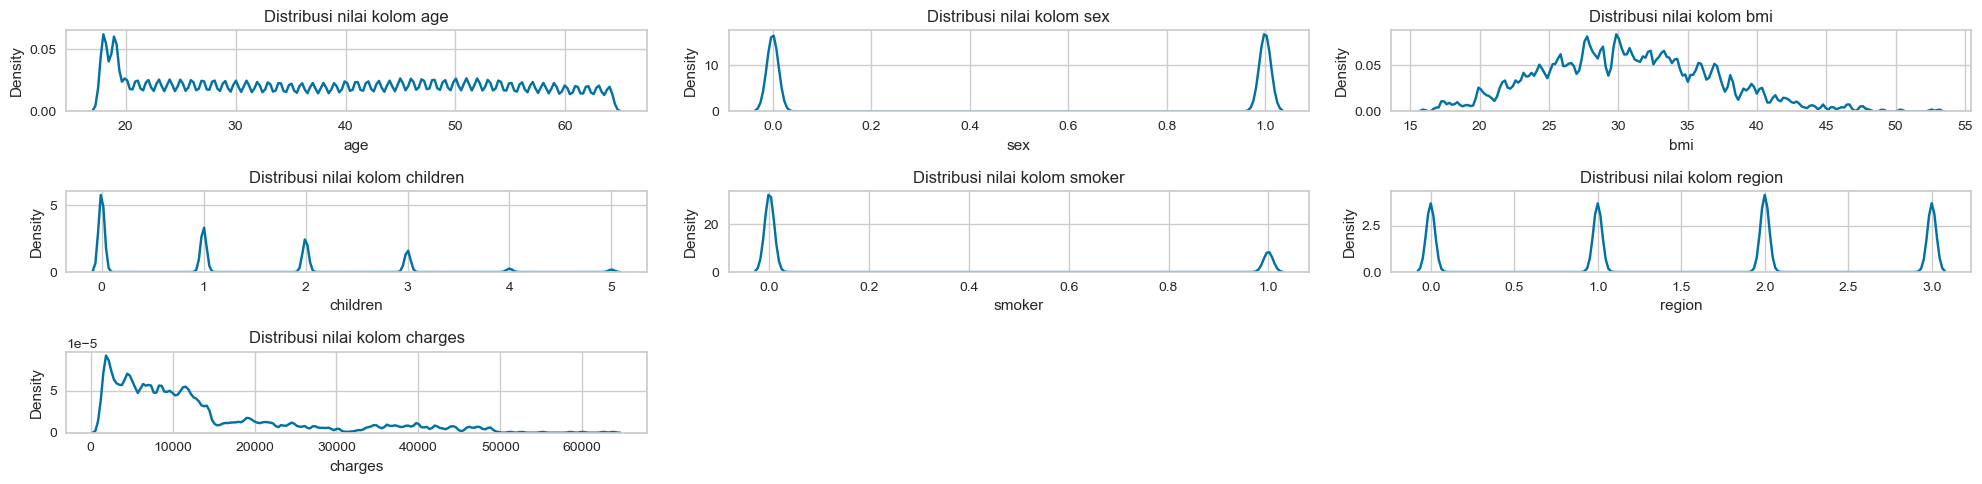

In [18]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# num_cols = 3
# num_rows = math.ceil(len(numerical_columns) / num_cols)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# for i, column in enumerate(numerical_columns):
#     row = i // num_cols
#     col = i % num_cols
#     sns.kdeplot(data=data, x=column, hue="Region", 
#                 fill=True, alpha=.2, palette="YlOrRd", 
#                 common_norm=False, ax=axes[row, col],
#                 warn_singular=False)\
#         .set_title(column)

# for i in range(len(numerical_columns), num_rows * num_cols):
#     row = i // num_cols
#     col = i % num_cols
#     axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

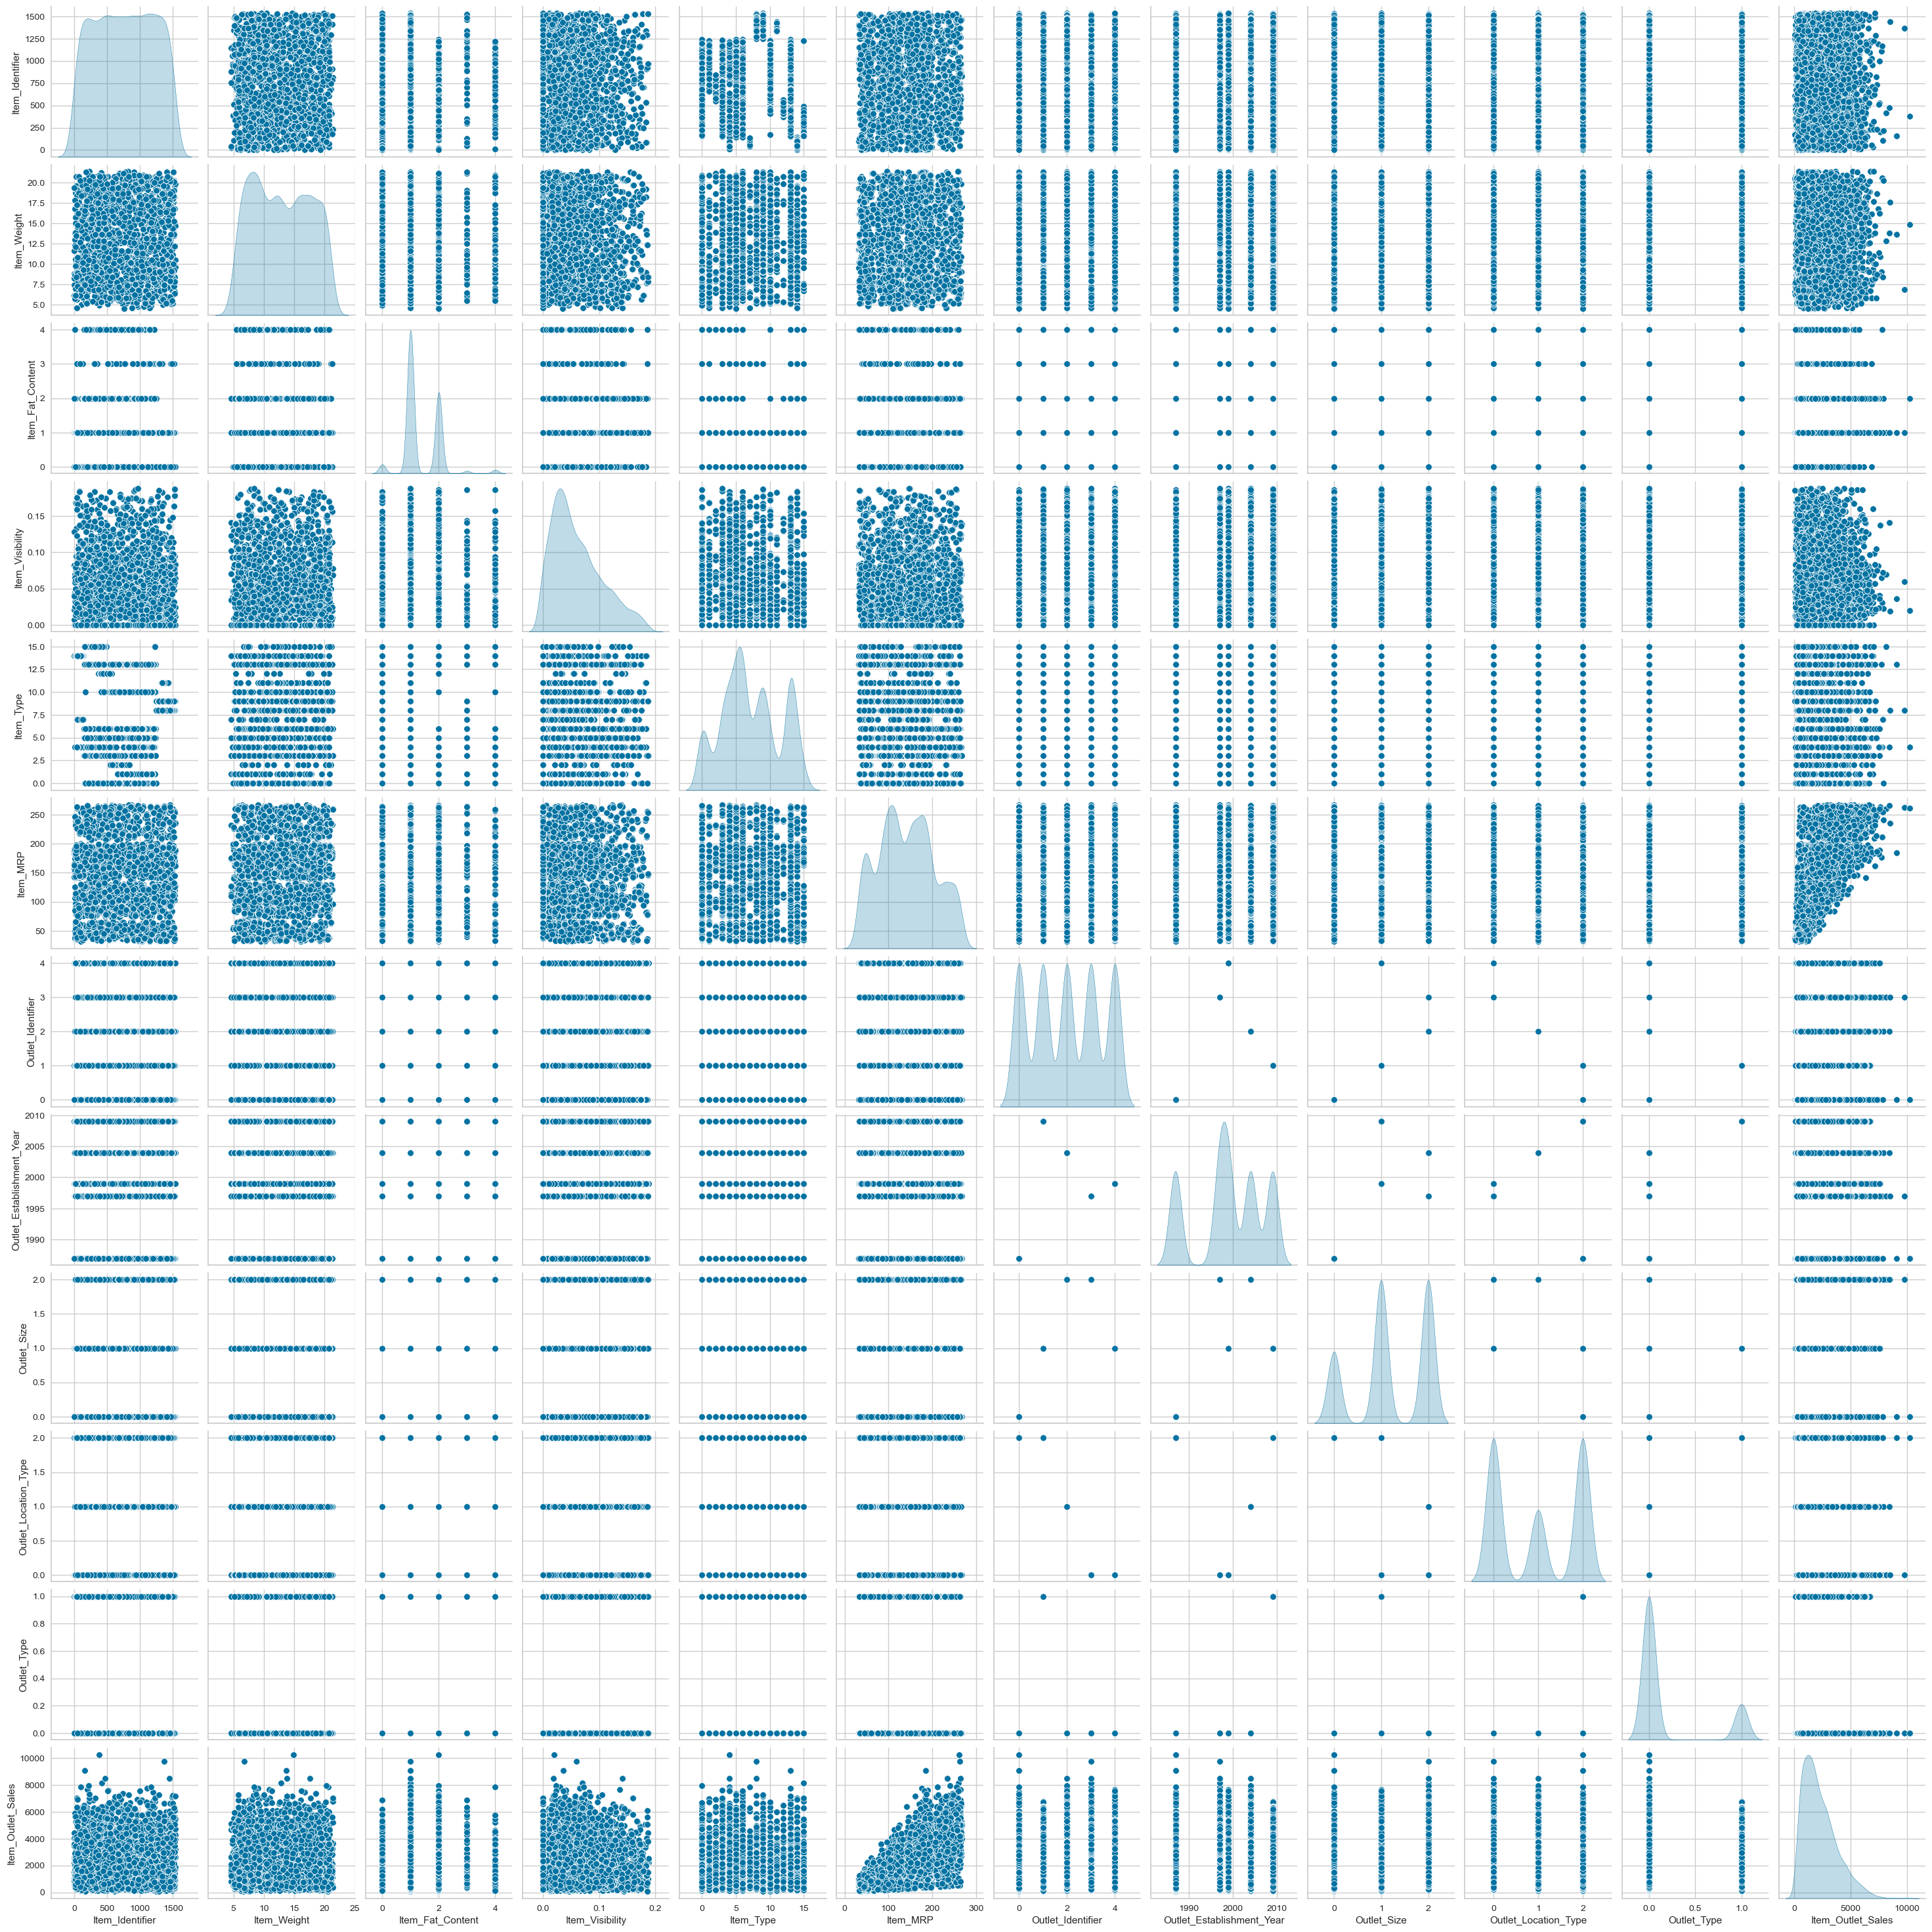

In [17]:
sns.pairplot(data, diag_kind="kde")
plt.show()

In [ ]:
# plt.subplots(figsize = (20,4))
# ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
# ax.bar_label(ax.containers[0])

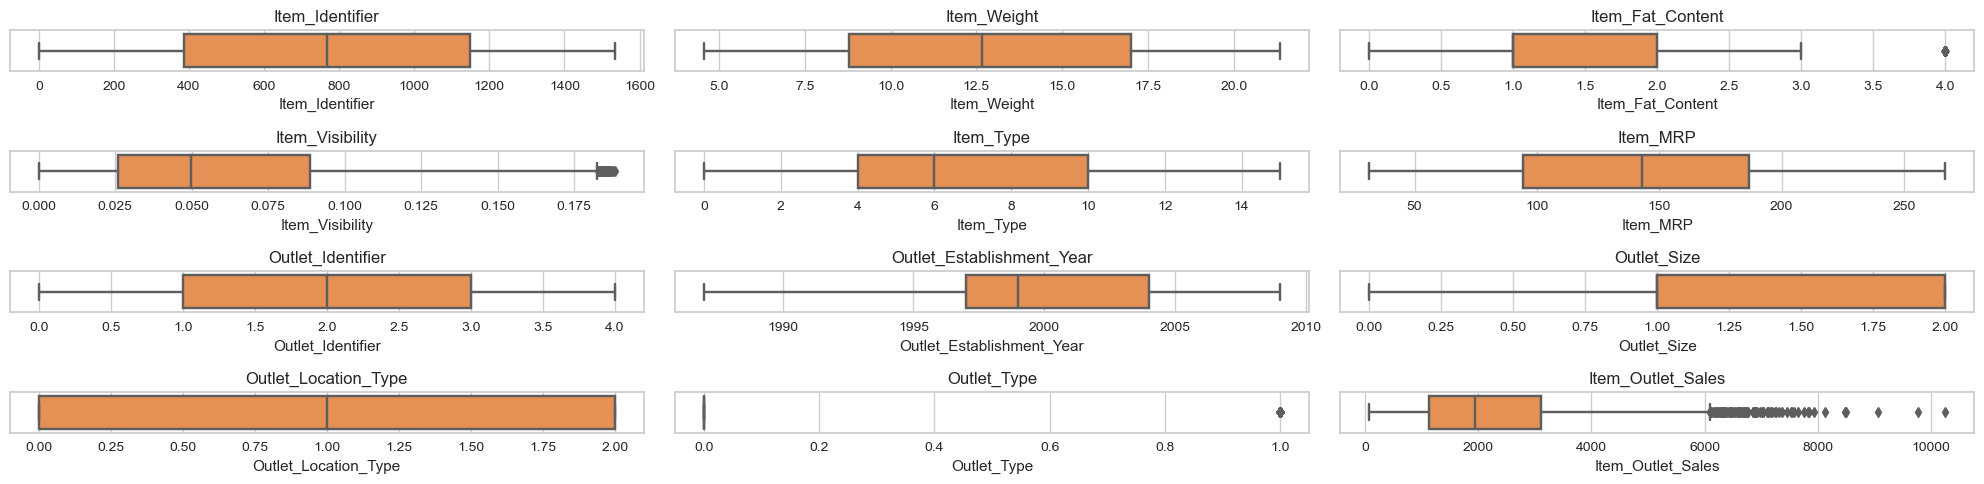

In [18]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### 3.4. Outliers

In [49]:
print(data['Sales'].quantile(.25))
print(data['Sales'].quantile(.75))

30453.0
52002.0


30453.0
52002.0


<Axes: xlabel='Sales'>

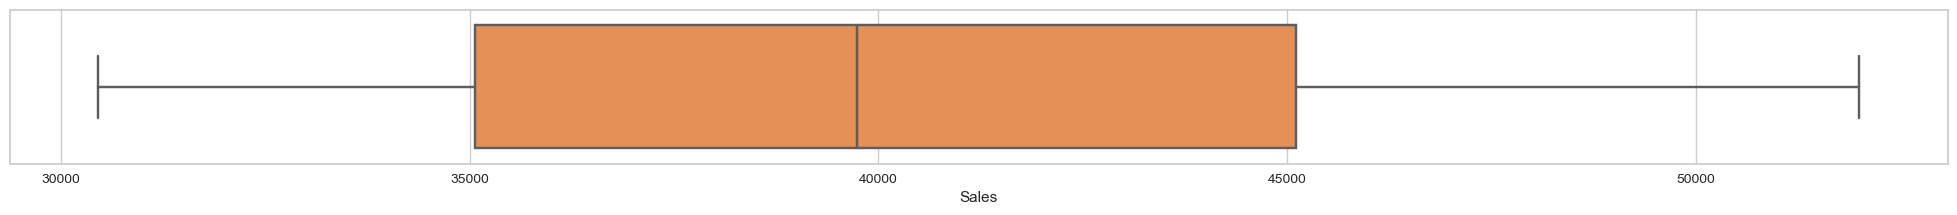

In [50]:
Q1 = data['Sales'].quantile(0.25)
Q3 = data['Sales'].quantile(.75)

print(Q1)
print(Q3)

data = data[(data['Sales'] > Q1) & (data['Sales'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['Sales'], palette="Oranges")

### 3.5. Data Correlation

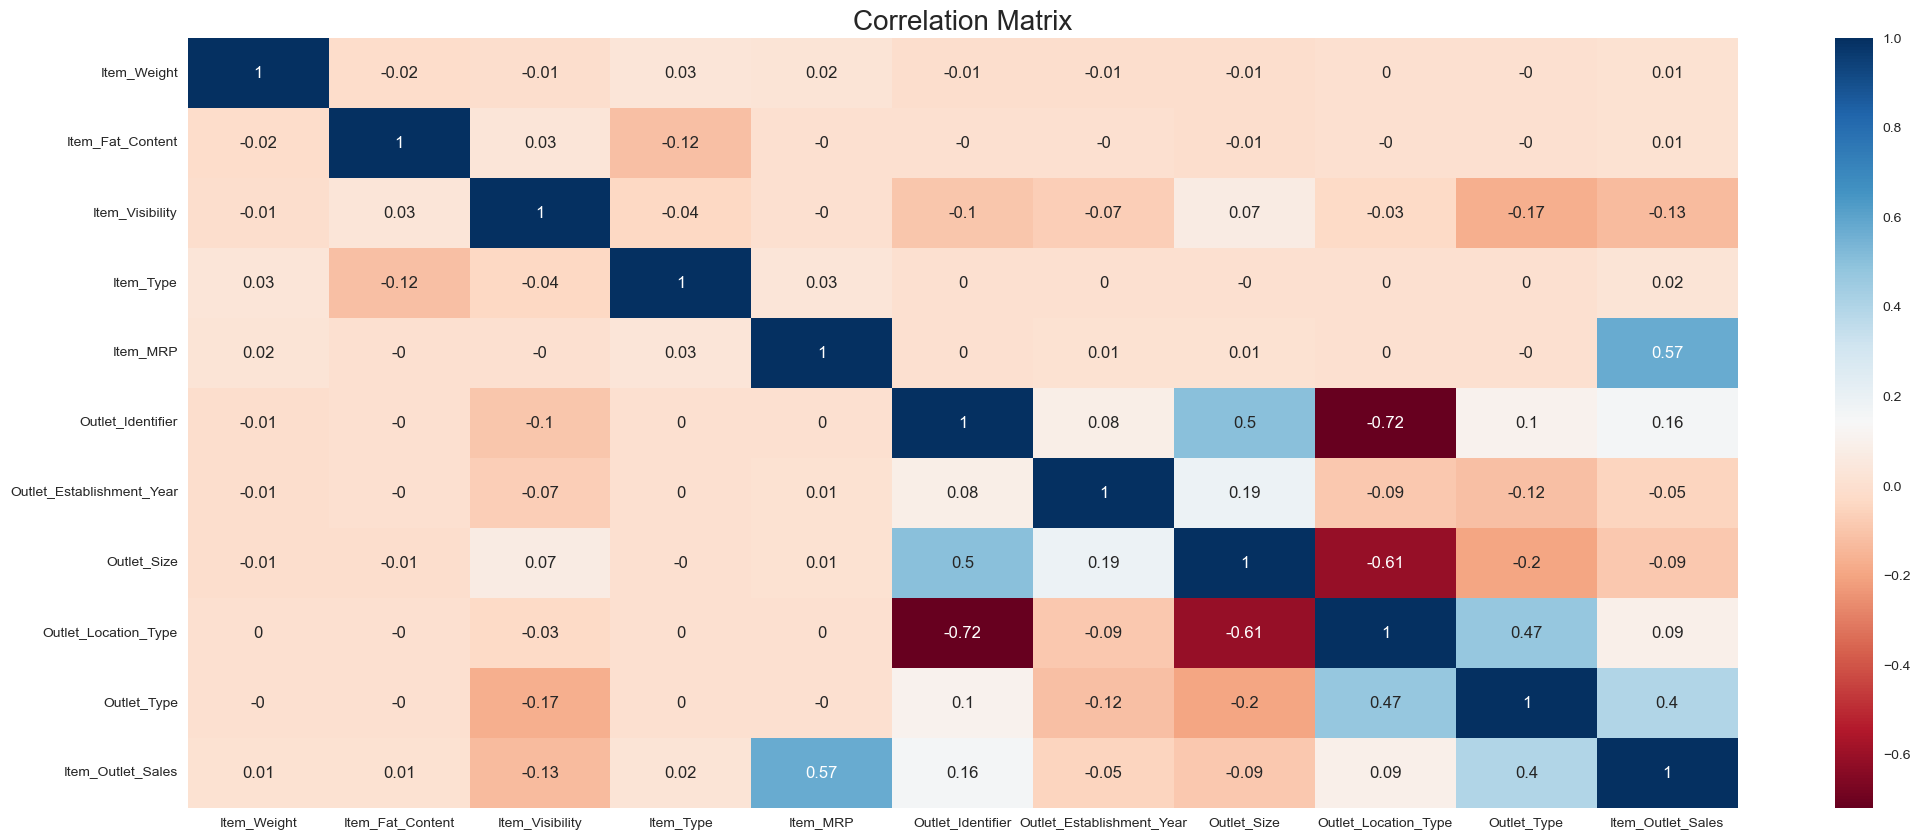

In [24]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)
plt.show()

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [55]:
features_column = data.columns

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = RobustScaler()
data = scaler.fit_transform(data)
scaler = PowerTransformer(method='yeo-johnson')
data = scaler.fit_transform(data)

data = pd.DataFrame(data, columns=features_column)

In [56]:
X = data.drop(columns=['Item_Outlet_Sales'])
Y = data['Item_Outlet_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(5982, 10) (5982,)
(1688, 10) (1688,)
(853, 10) (853,)


# 5. Neural Network Algoritms

In [57]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(Dense(1))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# model.compile(loss='mae', optimizer = opt, metrics=['mae'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1408      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 11,777
Trainable params: 11,777
Non-trainable params: 0
_________________________________________________________________


In [58]:
num_epoch = 100
batch_size = 32

history = model.fit(X_train, y_train, verbose=2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

Epoch 1/100
187/187 - 1s - loss: 2.0397 - mse: 0.6234 - val_loss: 1.7435 - val_mse: 0.3884 - 971ms/epoch - 5ms/step
Epoch 2/100
187/187 - 1s - loss: 1.6594 - mse: 0.3654 - val_loss: 1.5512 - val_mse: 0.3191 - 508ms/epoch - 3ms/step
Epoch 3/100
187/187 - 1s - loss: 1.5031 - mse: 0.3288 - val_loss: 1.4204 - val_mse: 0.3031 - 512ms/epoch - 3ms/step
Epoch 4/100
187/187 - 1s - loss: 1.3800 - mse: 0.3155 - val_loss: 1.3092 - val_mse: 0.2956 - 512ms/epoch - 3ms/step
Epoch 5/100
187/187 - 1s - loss: 1.2751 - mse: 0.3091 - val_loss: 1.2116 - val_mse: 0.2915 - 516ms/epoch - 3ms/step
Epoch 6/100
187/187 - 1s - loss: 1.1824 - mse: 0.3044 - val_loss: 1.1277 - val_mse: 0.2907 - 522ms/epoch - 3ms/step
Epoch 7/100
187/187 - 1s - loss: 1.1022 - mse: 0.3027 - val_loss: 1.0515 - val_mse: 0.2886 - 601ms/epoch - 3ms/step
Epoch 8/100
187/187 - 1s - loss: 1.0299 - mse: 0.3002 - val_loss: 0.9843 - val_mse: 0.2870 - 523ms/epoch - 3ms/step
Epoch 9/100
187/187 - 1s - loss: 0.9667 - mse: 0.2991 - val_loss: 0.9292

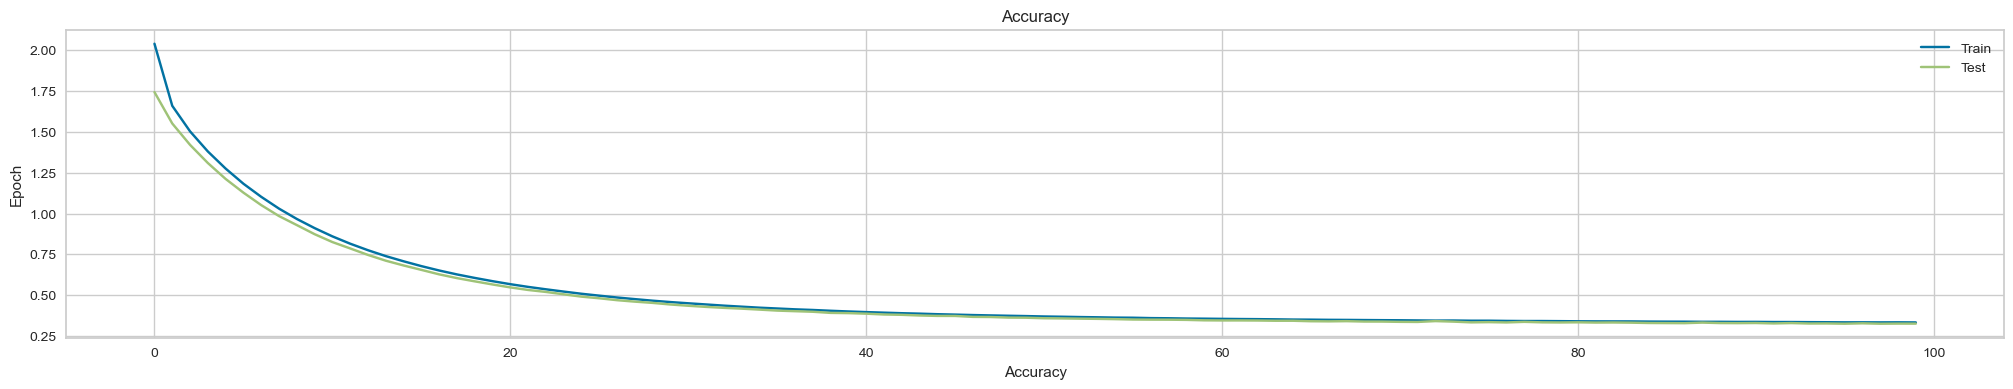

In [59]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [60]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

R Squared Error    : 0.67
Mean Squared Error : 0.34
Mean Absolute Error: 0.45


In [63]:
predictions = model.predict(X_test, verbose=0).flatten()

results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_test})
results['Diff'] = abs(results['Actuals'] - results['Predictions'])
print(results.head(5))
print('Max Error  : ',round(results['Diff'].max(), 3))
print('Mean Error : ',round(results['Diff'].mean(), 3))
print('Sum Diff   : ',round(results['Diff'].sum(), 3))


      Predictions   Actuals      Diff
7772     0.258821  0.949699  0.690878
4577    -0.938792 -1.263717  0.324925
3810    -1.569356 -1.895203  0.325847
519      1.602728  1.572617  0.030110
6479    -0.032158  0.918639  0.950796
Max Error  :  2.281
Mean Error :  0.452
Sum Diff   :  762.509


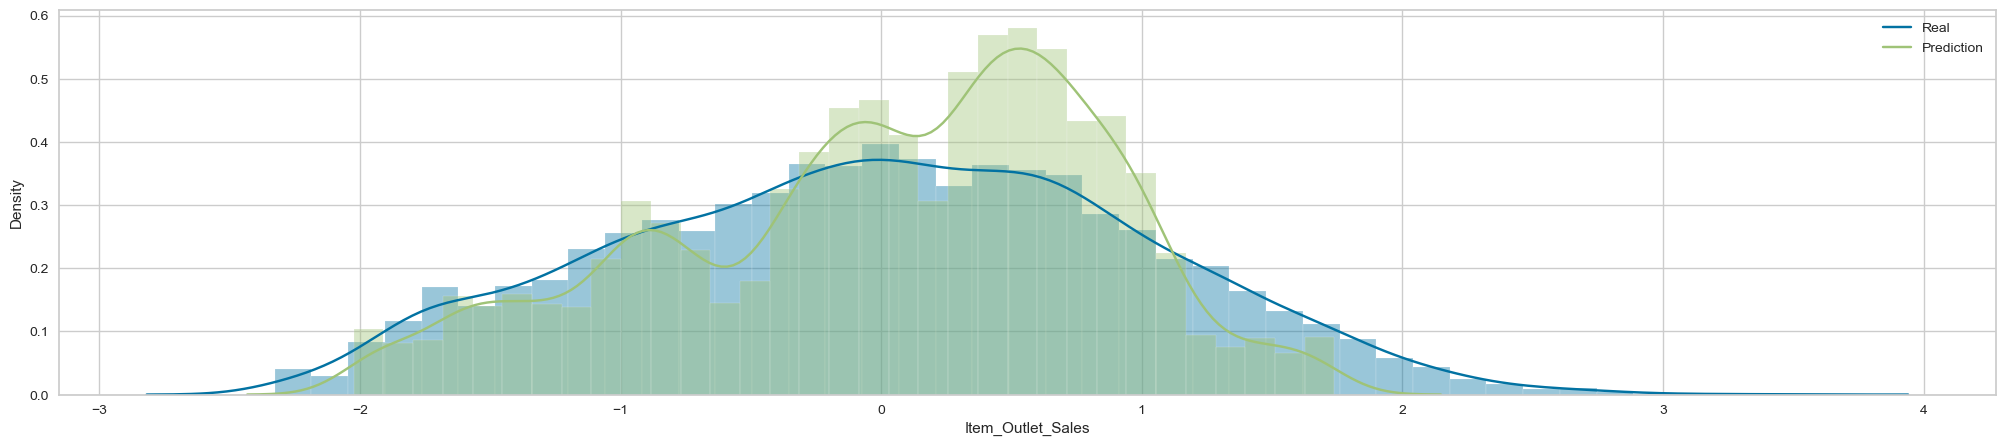

In [64]:
plt.subplots(figsize=(25,5))

features = data.loc[:, data.columns!='Item_Outlet_Sales']

prediction = model.predict(features, verbose=0)
sns.distplot(data['Item_Outlet_Sales'], kde=True)
sns.distplot(prediction, kde=True)
plt.legend(['Real', 'Prediction'])
plt.show()

In [66]:
data_x = data.loc[:, data.columns!='Item_Outlet_Sales']

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = (model.predict(data_x, verbose=0)).flatten()

data_pred = data.copy()
data_pred['Prediction'] = pd.DataFrame(predictions)
data_pred

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Prediction
0,-0.828189,-0.515529,-1.163069,-0.730088,1.687093,1.535907,-0.013719,-0.290112,-1.322433,-0.121612,0.986630,1.133582
1,-1.699366,1.008468,-1.044329,1.550107,-1.546821,-0.606537,1.544388,-0.290112,1.121995,1.040123,-1.208207,-1.074963
2,1.091665,-0.515529,-1.136496,0.672040,0.044695,1.535907,-0.013719,-0.290112,-1.322433,-0.121612,0.200726,0.270086
3,1.470262,1.008468,-1.822430,-0.247604,0.673248,-1.669174,-0.138359,-0.290112,1.121995,-1.921001,-0.840631,-1.121858
4,-0.920018,-0.515529,-1.822430,0.446549,-1.438693,-1.294843,-1.243051,-1.934924,1.121995,-0.121612,-0.580043,-0.774873
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,-1.447477,-0.515529,0.056839,1.333838,1.164365,-1.294843,-1.243051,-1.934924,1.121995,-0.121612,0.561176,0.829420
8519,-1.057885,1.008468,-0.187163,-1.849931,-0.490865,0.791563,0.394488,-0.290112,-0.215695,-0.121612,-1.059687,-0.080178
8520,-0.510643,-0.515529,-0.519394,0.218274,-0.876051,0.429375,0.695076,1.387270,-0.215695,-0.121612,-0.410223,-0.286538
8521,-1.357345,1.008468,1.424533,1.333838,-0.573395,-0.606537,1.544388,-0.290112,1.121995,1.040123,0.049895,-0.239128


# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [74]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor()
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)
linear = LinearRegression()

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    # ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
])

In [75]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                              ('XGB',
                               XGB...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_on

In [76]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')
print("Validationg Score  :",round((model.score(X_val, y_val)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

Train Score        : 81.28 %
Test Score         : 65.4 %
Validationg Score  : 70.79 %
R Squared Error    : 0.65
Mean Squared Error : 0.36
Mean Absolute Error: 0.46


In [77]:
predictions = model.predict(X_test).flatten()

results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_test})
results['Diff'] = abs(results['Actuals'] - results['Predictions'])
print(results.head(5))
print('Max Error  : ',round(results['Diff'].max(), 3))
print('Mean Error : ',round(results['Diff'].mean(), 3))
print('Sum Diff   : ',round(results['Diff'].sum(), 3))


      Predictions   Actuals      Diff
7772     0.310753  0.949699  0.638946
4577    -0.903589 -1.263717  0.360128
3810    -1.478834 -1.895203  0.416369
519      1.649579  1.572617  0.076961
6479    -0.029307  0.918639  0.947946
Max Error  :  2.462
Mean Error :  0.461
Sum Diff   :  778.629


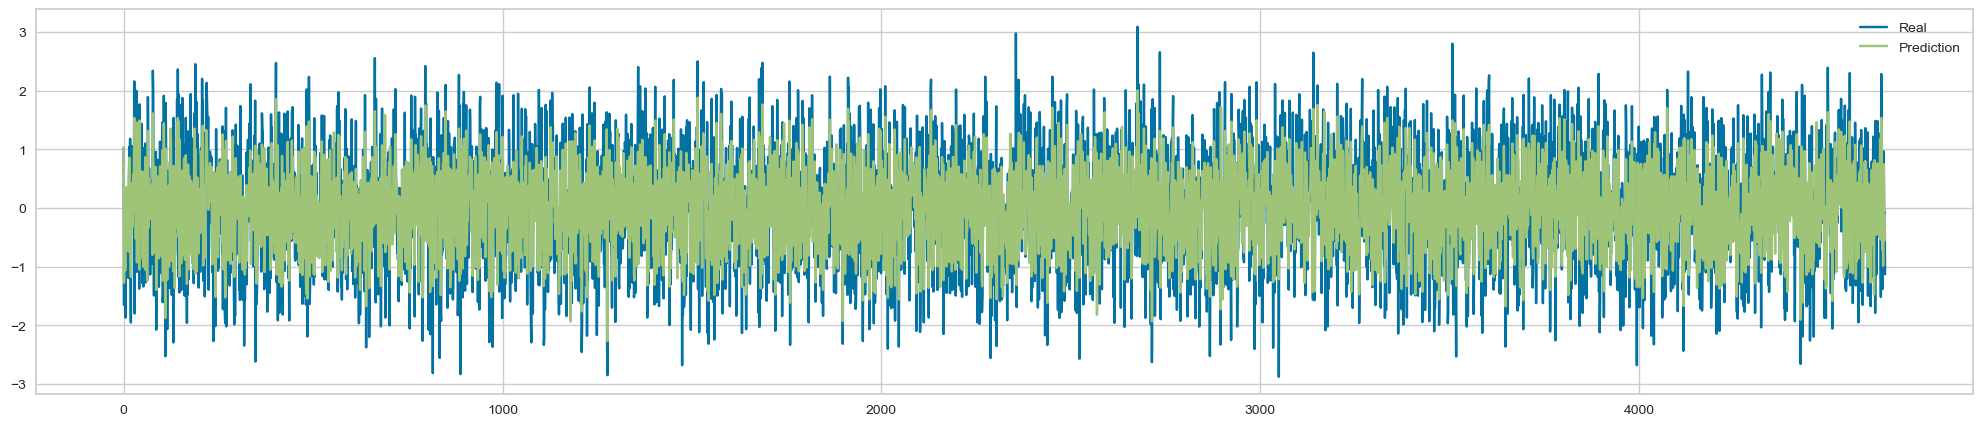

In [97]:
features = data.drop(columns=['Item_Outlet_Sales'])
prediction = model.predict(features)

fig, ax = plt.subplots(figsize=(25,5))
ax.plot(data['Item_Outlet_Sales'])
ax.plot(prediction)
plt.legend(['Real', 'Prediction'])
plt.show()

In [96]:
data_x = data.drop(columns=['Item_Outlet_Sales'])

# scaler = RobustScaler()
# data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = (model.predict(data_x)).flatten()

data_pred = data.copy()
data_pred['Prediction'] = pd.DataFrame(predictions)
data_pred

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Prediction
0,-0.733320,-0.514654,-1.119062,-0.710068,1.611243,1.336085,-0.035149,-0.319310,-1.151838,-0.499328,1.024744,1.055939
1,-1.597931,1.004241,-1.005033,1.502763,-1.606340,-0.645992,1.339516,-0.319310,1.078150,2.002692,-1.651073,-1.040755
2,0.982304,-0.514654,-1.093614,0.686000,0.069847,1.336085,-0.035149,-0.319310,-1.151838,-0.499328,0.112315,0.442481
3,-0.821757,-0.514654,-1.738851,0.470613,-1.487353,-1.500274,-1.639866,-1.547700,1.078150,-0.499328,-0.843327,-0.819534
4,-0.478739,1.004241,-1.738851,-1.930557,-1.539228,-0.645992,1.339516,-0.319310,1.078150,2.002692,-1.444479,-0.881625
...,...,...,...,...,...,...,...,...,...,...,...,...
4645,1.573043,3.146835,0.692559,-0.455931,0.630849,0.732444,-0.305978,1.094481,-1.151838,-0.499328,0.965429,0.759779
4646,-1.341876,-0.514654,0.100223,1.304428,1.136224,-1.500274,-1.639866,-1.547700,1.078150,-0.499328,0.535957,0.273346
4647,-0.432182,-0.514654,-0.490214,0.249644,-0.879103,0.079575,0.647884,1.094481,0.147376,-0.499328,-0.630872,-0.370732
4648,-1.251494,1.004241,1.632965,1.304428,-0.560197,-0.645992,1.339516,-0.319310,1.078150,2.002692,-0.068030,-0.291387


### 6.2. Pycarets

In [37]:
s = RegressionExperiment()
s.setup(data, target = 'Item_Outlet_Sales', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Item_Outlet_Sales
2,Target type,Regression
3,Original data shape,"(1705, 37)"
4,Transformed data shape,"(1705, 37)"
5,Transformed train set shape,"(1193, 37)"
6,Transformed test set shape,"(512, 37)"
7,Numeric features,36
8,Preprocess,True
9,Imputation type,simple


In [38]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:30:58
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


HuberRegressor()


In [ ]:
s.evaluate_model(best)

In [39]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,590.1542,797415.2204,892.9811,0.7127,0.4866,0.4199


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Overall Prediction,Item_Outlet_Sales,prediction_label
1134,12.150000,0.021757,165.018402,1999,0,1,0,0,0,0,...,1,0,0,0,1,0,0,2658,3302.367920,2684.177348
249,9.800000,0.141406,50.000801,2007,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1643,506.007996,1572.491272
1143,6.135000,0.079327,152.836594,1997,0,0,1,0,0,1,...,1,0,0,0,1,0,0,2648,2871.595459,2468.206772
809,12.911574,0.124300,73.469597,1985,0,1,0,0,0,0,...,1,0,0,1,0,0,0,313,298.278412,381.094023
657,6.920000,0.038447,63.585201,2004,0,1,0,0,0,0,...,0,1,0,0,1,0,0,883,751.022400,950.244089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,17.200001,0.025162,145.941803,2004,0,0,1,0,0,0,...,0,1,0,0,1,0,0,2694,1765.701660,2689.931096
1688,9.800000,0.026895,128.401993,2002,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1637,2403.538086,1719.376834
1612,16.000000,0.173463,157.697205,2009,0,0,1,0,0,0,...,0,0,1,0,0,1,0,2359,2960.146729,2184.149560
954,9.800000,0.013830,45.306000,1987,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1388,1304.968018,1318.843237


# 7. AutoTS

In [10]:
model = AutoTS(forecast_length=30, frequency='infer', ensemble='simple')
model = model.fit(data, date_col='Date', value_col='Close', id_col=None)

Inferred frequency is: B
Model Number: 1 with model ARIMA in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10
Model Number: 7 with model DatepartRegression in generation 0 of 10
Model Number: 8 with model DatepartRegression in generation 0 of 10
Epoch 1/50
211/211 [==============================] - 5s 6ms/step - loss: 0.4015
Epoch 2/50
211/211 [==============================] - 1s 6ms/step - loss: 0.4004
Epoch 3/50
211/211 [==============================] - 1s 6ms/step - loss: 0.4004
Epoch 4/50
211/211 [==============================] - 1s 6ms/step - loss: 0.4006
Epoch 5/50
211/211 [==============================] - 1s 6ms/step - loss: 0.4003
Epoch 6/50
211/211 [======================

16:02:40 - cmdstanpy - INFO - Chain [1] start processing
16:02:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 37 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 10
Model Number: 39 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 10
Model Number: 42 with model DatepartRegression in generation 0 of 10
Model Number: 43 with model UnobservedComponents in generation 0 of 10
Model Number: 44 with model UnobservedComponents in generation 0 of 10
Model

16:02:46 - cmdstanpy - INFO - Chain [1] start processing
16:02:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 56 with model SeasonalNaive in generation 0 of 10
Model Number: 57 with model DatepartRegression in generation 0 of 10
Model Number: 58 with model NVAR in generation 0 of 10
Model Number: 59 with model Theta in generation 0 of 10
Model Number: 60 with model UnivariateRegression in generation 0 of 10
Model Number: 61 with model ARCH in generation 0 of 10
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 61 in generation 0: ARCH
Model Number: 62 with model ConstantNaive in generation 0 of 10
Model Number: 63 with model LastValueNaive in generation 0 of 10
Model Number: 64 with model AverageValueNaive in generation 0 of 10
Model Number: 65 with model GLS in generation 0 of 10
Model Number: 66 with model SeasonalNaive in generation 0 of 10
Model Number: 67 with model GLM in generation 0 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 67 in generation 0: GLM
Model Number: 68 with model E

16:02:50 - cmdstanpy - INFO - Chain [1] start processing
16:02:56 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 70 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 70 in generation 0: GluonTS
Model Number: 71 with model UnobservedComponents in generation 0 of 10
Model Number: 72 with model VAR in generation 0 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError('Only gave one variable to VAR') in model 72 in generation 0: VAR
Model Number: 73 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 73 in generation 0: VECM
Model Number: 74 with model ARIMA in generation 0 of 10
Model Number: 75 with model WindowRegression in generation 0 of 10
Model Number: 76 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 76 in generation 0: DatepartRegression
Model Number: 77 with model

16:04:01 - cmdstanpy - INFO - Chain [1] start processing
16:04:04 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 172 with model AverageValueNaive in generation 0 of 10
Model Number: 173 with model MultivariateMotif in generation 0 of 10
Model Number: 174 with model Theta in generation 0 of 10
Model Number: 175 with model GLM in generation 0 of 10
Model Number: 176 with model UnivariateMotif in generation 0 of 10
Model Number: 177 with model ARDL in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 177 in generation 0: ARDL
Model Number: 178 with model MultivariateMotif in generation 0 of 10
Model Number: 179 with model NVAR in generation 0 of 10
Model Number: 180 with model UnivariateMotif in generation 0 of 10
Model Number: 181 with model Theta in generation 0 of 10
Model Number: 182 with model SectionalMotif in generation 0 of 10
Model Number: 183 with model ARIMA in generation 0 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 183 in generation 0: ARIMA
Model Number: 184 with m

16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 217 with model MetricMotif in generation 1 of 10
Model Number: 218 with model LastValueNaive in generation 1 of 10
Model Number: 219 with model UnobservedComponents in generation 1 of 10
Model Number: 220 with model UnivariateMotif in generation 1 of 10
Model Number: 221 with model ARDL in generation 1 of 10
Model Number: 222 with model ARIMA in generation 1 of 10
Model Number: 223 with model NVAR in generation 1 of 10
Model Number: 224 with model NVAR in generation 1 of 10
Model Number: 225 with model Theta in generation 1 of 10
Model Number: 226 with model ETS in generation 1 of 10
Model Number: 227 with model MetricMotif in generation 1 of 10
Model Number: 228 with model ETS in generation 1 of 10
Model Number: 229 with model UnivariateMotif in generation 1 of 10
Model Number: 230 with model WindowRegression in generation 1 of 10
Model Number: 231 with model AverageValueNaive in generation 1 of 10
Model Number: 232 with model LastValueNaive in generation 1 of 10
Model N

16:05:39 - cmdstanpy - INFO - Chain [1] start processing
16:05:42 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 309 with model UnobservedComponents in generation 1 of 10
Model Number: 310 with model NVAR in generation 1 of 10
Model Number: 311 with model DatepartRegression in generation 1 of 10
New Generation: 2 of 10
Model Number: 312 with model AverageValueNaive in generation 2 of 10
Model Number: 313 with model AverageValueNaive in generation 2 of 10
Model Number: 314 with model AverageValueNaive in generation 2 of 10
Model Number: 315 with model ARIMA in generation 2 of 10
Model Number: 316 with model GLS in generation 2 of 10
Model Number: 317 with model MetricMotif in generation 2 of 10
Model Number: 318 with model NVAR in generation 2 of 10
Model Number: 319 with model ARIMA in generation 2 of 10
Model Number: 320 with model SeasonalNaive in generation 2 of 10
Model Number: 321 with model MetricMotif in generation 2 of 10
Model Number: 322 with model ETS in generation 2 of 10
Model Number: 323 with model UnivariateMotif in generation 2 of 10
Model Number: 324 with model NVAR

16:09:16 - cmdstanpy - INFO - Chain [1] start processing
16:09:20 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 366 with model MetricMotif in generation 2 of 10
Model Number: 367 with model GLM in generation 2 of 10
Model Number: 368 with model GLS in generation 2 of 10
Model Number: 369 with model AverageValueNaive in generation 2 of 10
Model Number: 370 with model MultivariateMotif in generation 2 of 10
Model Number: 371 with model MetricMotif in generation 2 of 10
Model Number: 372 with model UnivariateMotif in generation 2 of 10
Model Number: 373 with model MultivariateMotif in generation 2 of 10
Model Number: 374 with model WindowRegression in generation 2 of 10
Model Number: 375 with model Theta in generation 2 of 10
Model Number: 376 with model Theta in generation 2 of 10
Model Number: 377 with model UnivariateMotif in generation 2 of 10
Model Number: 378 with model LastValueNaive in generation 2 of 10
Model Number: 379 with model MetricMotif in generation 2 of 10
Model Number: 380 with model LastValueNaive in generation 2 of 10
Model Number: 381 with model MultivariateRegre

16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:15 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 423 with model UnivariateMotif in generation 2 of 10
Model Number: 424 with model ARIMA in generation 2 of 10
Model Number: 425 with model AverageValueNaive in generation 2 of 10
Model Number: 426 with model NVAR in generation 2 of 10
Model Number: 427 with model NVAR in generation 2 of 10
Model Number: 428 with model AverageValueNaive in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 428 in generation 2: AverageValueNaive
Model Number: 429 with model FBProphet in generation 2 of 10


16:10:20 - cmdstanpy - INFO - Chain [1] start processing
16:10:22 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 430 with model MultivariateMotif in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 430 in generation 2: MultivariateMotif
Model Number: 431 with model MultivariateMotif in generation 2 of 10
Model Number: 432 with model ARIMA in generation 2 of 10
Model Number: 433 with model UnivariateMotif in generation 2 of 10
Model Number: 434 with model NVAR in generation 2 of 10
Model Number: 435 with model UnivariateMotif in generation 2 of 10
Model Number: 436 with model ETS in generation 2 of 10
New Generation: 3 of 10
Model Number: 437 with model MultivariateMotif in generation 3 of 10
Model Number: 438 with model AverageValueNaive in generation 3 of 10
Model Number: 439 with model UnivariateMotif in generation 3 of 10
Model Number: 440 with model ARDL in generation 3 of 10
Model Number: 441 with model UnivariateMotif in generation 3 of 10
Model Number: 442 with model MetricMotif in generation 3 of 10
Model Number: 443 with 

16:11:42 - cmdstanpy - INFO - Chain [1] start processing
16:11:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 453 with model GLS in generation 3 of 10
Model Number: 454 with model AverageValueNaive in generation 3 of 10
Model Number: 455 with model NVAR in generation 3 of 10
Model Number: 456 with model WindowRegression in generation 3 of 10
Model Number: 457 with model UnivariateRegression in generation 3 of 10
Model Number: 458 with model Theta in generation 3 of 10
Model Number: 459 with model NVAR in generation 3 of 10
Model Number: 460 with model ConstantNaive in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 460 in generation 3: ConstantNaive
Model Number: 461 with model AverageValueNaive in generation 3 of 10
Model Number: 462 with model MultivariateMotif in generation 3 of 10
Model Number: 463 with model UnivariateMotif in generation 3 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 463 in generation 3: UnivariateMotif
Model Number: 464 with model MultivariateMotif in generation 3 of 10

16:12:05 - cmdstanpy - INFO - Chain [1] start processing
16:12:08 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 469 with model ConstantNaive in generation 3 of 10
Model Number: 470 with model GLS in generation 3 of 10
Model Number: 471 with model AverageValueNaive in generation 3 of 10
Model Number: 472 with model UnivariateMotif in generation 3 of 10
Model Number: 473 with model AverageValueNaive in generation 3 of 10
Model Number: 474 with model UnivariateMotif in generation 3 of 10
Model Number: 475 with model Theta in generation 3 of 10
Model Number: 476 with model MetricMotif in generation 3 of 10
Model Number: 477 with model UnobservedComponents in generation 3 of 10
Model Number: 478 with model ARDL in generation 3 of 10
Model Number: 479 with model SectionalMotif in generation 3 of 10
Model Number: 480 with model UnivariateMotif in generation 3 of 10
Model Number: 481 with model NVAR in generation 3 of 10
Model Number: 482 with model MultivariateMotif in generation 3 of 10
Model Number: 483 with model ConstantNaive in generation 3 of 10
Template Eval Error: ValueError("Mode

16:12:48 - cmdstanpy - INFO - Chain [1] start processing
16:12:50 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 532 with model ConstantNaive in generation 3 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill', 'transformations': {'0': 'AlignLastValue', '1': 'Detrend', '2': 'bkfilter', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'rows': 1, 'lag': 28, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '1': {'model': 'GLS', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_on_forecast_nan=True") in model 532 in generation 3: ConstantNaive
Model Number: 533 with model ARIMA in generation 3 of 10
Model Number: 534 with model ConstantNaive in generation 3 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill', 'transformations': {'0': 'PowerTransformer', '1': 'QuantileTransformer', '2': 'bkfilter', '3': 'AlignLastValue'}, 'transfo

16:13:31 - cmdstanpy - INFO - Chain [1] start processing
16:13:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 588 with model UnivariateMotif in generation 4 of 10
Model Number: 589 with model ARIMA in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 589 in generation 4: ARIMA
Model Number: 590 with model SectionalMotif in generation 4 of 10
Model Number: 591 with model LastValueNaive in generation 4 of 10
Model Number: 592 with model MultivariateRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 592 in generation 4: MultivariateRegression
Model Number: 593 with model WindowRegression in generation 4 of 10
Model Number: 594 with model MetricMotif in generation 4 of 10
Model Number: 595 with model UnivariateMotif in generation 4 of 10
Model Number: 596 with model FBProphet in generation 4 of 10


16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:39 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 597 with model NVAR in generation 4 of 10
Model Number: 598 with model Theta in generation 4 of 10
Model Number: 599 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on Close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 600 with model SectionalMotif in generation 4 of 10
Model Number: 601 with model MultivariateRegression in generation 4 of 10
Model Number: 602 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on Close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 603 with model AverageValueNaive in generation 4 of 10
Model Number: 604 with model MultivariateRegression in generation 4 of 10
Model Number: 605 wi

16:14:02 - cmdstanpy - INFO - Chain [1] start processing
16:14:05 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 627 with model UnobservedComponents in generation 4 of 10
Model Number: 628 with model UnivariateMotif in generation 4 of 10
Model Number: 629 with model LastValueNaive in generation 4 of 10
Model Number: 630 with model UnivariateRegression in generation 4 of 10
Template Eval Error: ValueError("Input contains NaN, infinity or a value too large for dtype('float64').") in model 630 in generation 4: UnivariateRegression
Model Number: 631 with model UnivariateMotif in generation 4 of 10
Model Number: 632 with model SeasonalNaive in generation 4 of 10
Model Number: 633 with model NVAR in generation 4 of 10
Model Number: 634 with model MultivariateMotif in generation 4 of 10
Model Number: 635 with model ETS in generation 4 of 10
Model Number: 636 with model FBProphet in generation 4 of 10


16:14:11 - cmdstanpy - INFO - Chain [1] start processing
16:14:14 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 637 with model UnobservedComponents in generation 4 of 10
Model Number: 638 with model UnobservedComponents in generation 4 of 10
Model Number: 639 with model MetricMotif in generation 4 of 10
Model Number: 640 with model ETS in generation 4 of 10
Model Number: 641 with model ARDL in generation 4 of 10
Model Number: 642 with model AverageValueNaive in generation 4 of 10
Model Number: 643 with model LastValueNaive in generation 4 of 10
Model Number: 644 with model UnobservedComponents in generation 4 of 10
Model Number: 645 with model UnobservedComponents in generation 4 of 10
Model Number: 646 with model NVAR in generation 4 of 10
Model Number: 647 with model ARIMA in generation 4 of 10
Model Number: 648 with model FBProphet in generation 4 of 10


16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 649 with model SectionalMotif in generation 4 of 10
Model Number: 650 with model Theta in generation 4 of 10
Model Number: 651 with model GLS in generation 4 of 10
Model Number: 652 with model MultivariateMotif in generation 4 of 10
Model Number: 653 with model WindowRegression in generation 4 of 10
Model Number: 654 with model GLM in generation 4 of 10
Model Number: 655 with model ARIMA in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 655 in generation 4: ARIMA
Model Number: 656 with model MultivariateRegression in generation 4 of 10
Model Number: 657 with model GLS in generation 4 of 10
Model Number: 658 with model ARDL in generation 4 of 10
Model Number: 659 with model LastValueNaive in generation 4 of 10
Model Number: 660 with model UnivariateMotif in generation 4 of 10
Model Number: 661 with model WindowRegression in generation 4 of 10
Model Number: 662 with model MetricMotif in generation 4 of

16:18:27 - cmdstanpy - INFO - Chain [1] start processing
16:18:27 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 723 with model MultivariateMotif in generation 5 of 10
Model Number: 724 with model ARIMA in generation 5 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 724 in generation 5: ARIMA
Model Number: 725 with model SeasonalNaive in generation 5 of 10
Model Number: 726 with model MultivariateRegression in generation 5 of 10
Model Number: 727 with model MetricMotif in generation 5 of 10
Model Number: 728 with model MetricMotif in generation 5 of 10
Model Number: 729 with model LastValueNaive in generation 5 of 10
Model Number: 730 with model FBProphet in generation 5 of 10


16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:35 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 731 with model ETS in generation 5 of 10
Model Number: 732 with model FBProphet in generation 5 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 732 in generation 5: FBProphet
Model Number: 733 with model Theta in generation 5 of 10
Model Number: 734 with model UnivariateMotif in generation 5 of 10
Model Number: 735 with model NVAR in generation 5 of 10
Model Number: 736 with model Theta in generation 5 of 10
Model Number: 737 with model MultivariateMotif in generation 5 of 10
Model Number: 738 with model UnivariateMotif in generation 5 of 10
Model Number: 739 with model ETS in generation 5 of 10
Model Number: 740 with model MetricMotif in generation 5 of 10
Model Number: 741 with model ConstantNaive in generation 5 of 10
Model Number: 742 with model LastValueNaive in generation 5 of 10
Model Number: 743 with model ETS in generation 5 of 10
Model Number: 744 with model AverageValueNaive in generation 5 of 10
Model Number: 745 with m

16:18:48 - cmdstanpy - INFO - Chain [1] start processing
16:18:54 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 748 with model NVAR in generation 5 of 10
Model Number: 749 with model NVAR in generation 5 of 10
Model Number: 750 with model MultivariateMotif in generation 5 of 10
Model Number: 751 with model ARDL in generation 5 of 10
Model Number: 752 with model UnivariateRegression in generation 5 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 752 in generation 5: UnivariateRegression
Model Number: 753 with model LastValueNaive in generation 5 of 10
Model Number: 754 with model UnobservedComponents in generation 5 of 10
Model Number: 755 with model Theta in generation 5 of 10
Model Number: 756 with model UnobservedComponents in generation 5 of 10
Model Number: 757 with model UnivariateMotif in generation 5 of 10
Model Number: 758 with model UnivariateMotif in generation 5 of 10
Model Number: 759 with model MetricMotif in generation 5 of 10
Model Number: 760 with model NVAR in generation 5 of 10
Model Number: 761 with model UnivariateMotif in generat

16:19:18 - cmdstanpy - INFO - Chain [1] start processing
16:19:22 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 776 with model NVAR in generation 5 of 10
Model Number: 777 with model AverageValueNaive in generation 5 of 10
Model Number: 778 with model AverageValueNaive in generation 5 of 10
Model Number: 779 with model MultivariateRegression in generation 5 of 10
Epoch 1/50
94/94 [==============================] - 3s 7ms/step - loss: 1224.0608
Epoch 2/50
94/94 [==============================] - 0s 5ms/step - loss: 1459.6967
Epoch 3/50
94/94 [==============================] - 0s 5ms/step - loss: 863.3812
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 563.7917
Epoch 5/50
94/94 [==============================] - 1s 6ms/step - loss: 1488.4980
Epoch 6/50
94/94 [==============================] - 1s 5ms/step - loss: 579.8615
Epoch 7/50
94/94 [==============================] - 0s 5ms/step - loss: 632.3624
Epoch 8/50
94/94 [==============================] - 0s 5ms/step - loss: 519.9792
Epoch 9/50
94/94 [==============================] - 1s 5ms/step - loss: 624.8746


16:20:45 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 794 with model NVAR in generation 6 of 10
Model Number: 795 with model ConstantNaive in generation 6 of 10
Model Number: 796 with model NVAR in generation 6 of 10
Model Number: 797 with model MetricMotif in generation 6 of 10
Model Number: 798 with model ConstantNaive in generation 6 of 10
Model Number: 799 with model LastValueNaive in generation 6 of 10
Model Number: 800 with model MultivariateRegression in generation 6 of 10
Model Number: 801 with model MetricMotif in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 801 in generation 6: MetricMotif
Model Number: 802 with model SectionalMotif in generation 6 of 10
Model Number: 803 with model MetricMotif in generation 6 of 10
Model Number: 804 with model MultivariateMotif in generation 6 of 10
Model Number: 805 with model ARIMA in generation 6 of 10
Model Number: 806 with model UnobservedComponents in generation 6 of 10
Model Number: 807 with model Theta in generation 6 of 10
T

16:21:07 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 810 with model UnivariateMotif in generation 6 of 10
Model Number: 811 with model Theta in generation 6 of 10
Model Number: 812 with model NVAR in generation 6 of 10
Model Number: 813 with model UnobservedComponents in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 813 in generation 6: UnobservedComponents
Model Number: 814 with model NVAR in generation 6 of 10
Model Number: 815 with model MetricMotif in generation 6 of 10
Model Number: 816 with model MetricMotif in generation 6 of 10
Model Number: 817 with model DatepartRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 817 in generation 6: DatepartRegression
Model Number: 818 with model AverageValueNaive in generation 6 of 10
Model Number: 819 with model MultivariateMotif in generation 6 of 10
Model Number: 820 with model LastValueNaive in generation 6 of 10
Model Number: 821 with model 

16:21:28 - cmdstanpy - INFO - Chain [1] start processing
16:21:29 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 848 with model MultivariateRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 848 in generation 6: MultivariateRegression
Model Number: 849 with model ARIMA in generation 6 of 10
Model Number: 850 with model UnobservedComponents in generation 6 of 10
Model Number: 851 with model Theta in generation 6 of 10
Model Number: 852 with model NVAR in generation 6 of 10
Model Number: 853 with model MetricMotif in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 853 in generation 6: MetricMotif
Model Number: 854 with model ARDL in generation 6 of 10
Model Number: 855 with model MultivariateRegression in generation 6 of 10
Model Number: 856 with model MultivariateMotif in generation 6 of 10
Model Number: 857 with model MetricMotif in generation 6 of 10
Model Number: 858 with model UnobservedComponents in generation 6 of 10
Model Number: 859 with model ETS i

16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 867 with model Theta in generation 6 of 10
Model Number: 868 with model UnivariateMotif in generation 6 of 10
Model Number: 869 with model UnivariateMotif in generation 6 of 10
Model Number: 870 with model UnivariateMotif in generation 6 of 10
Model Number: 871 with model NVAR in generation 6 of 10
Model Number: 872 with model GLS in generation 6 of 10
Model Number: 873 with model ETS in generation 6 of 10
Model Number: 874 with model GLM in generation 6 of 10
Model Number: 875 with model MultivariateRegression in generation 6 of 10
Model Number: 876 with model UnivariateMotif in generation 6 of 10
Model Number: 877 with model FBProphet in generation 6 of 10


16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:54 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 878 with model GLS in generation 6 of 10
Model Number: 879 with model SectionalMotif in generation 6 of 10
Model Number: 880 with model NVAR in generation 6 of 10
Model Number: 881 with model AverageValueNaive in generation 6 of 10
Model Number: 882 with model DatepartRegression in generation 6 of 10
Model Number: 883 with model WindowRegression in generation 6 of 10
Model Number: 884 with model NVAR in generation 6 of 10
Model Number: 885 with model ARDL in generation 6 of 10
Model Number: 886 with model UnivariateMotif in generation 6 of 10
New Generation: 7 of 10
Model Number: 887 with model UnobservedComponents in generation 7 of 10
Model Number: 888 with model MetricMotif in generation 7 of 10
Model Number: 889 with model GLS in generation 7 of 10
Model Number: 890 with model SectionalMotif in generation 7 of 10
Model Number: 891 with model AverageValueNaive in generation 7 of 10
Model Number: 892 with model ARDL in generation 7 of 10
Model Number: 893 with model Uni

16:22:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:00 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 954 with model FBProphet in generation 7 of 10


16:23:00 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 955 with model ETS in generation 7 of 10
Model Number: 956 with model ETS in generation 7 of 10
Model Number: 957 with model SectionalMotif in generation 7 of 10
Model Number: 958 with model SectionalMotif in generation 7 of 10
Model Number: 959 with model NVAR in generation 7 of 10
Model Number: 960 with model MultivariateRegression in generation 7 of 10
Model Number: 961 with model UnivariateMotif in generation 7 of 10
Model Number: 962 with model ARIMA in generation 7 of 10
Model Number: 963 with model MultivariateRegression in generation 7 of 10
Model Number: 964 with model GLS in generation 7 of 10
Model Number: 965 with model UnivariateMotif in generation 7 of 10
Model Number: 966 with model UnivariateMotif in generation 7 of 10
Model Number: 967 with model WindowRegression in generation 7 of 10
Model Number: 968 with model ETS in generation 7 of 10
Model Number: 969 with model ETS in generation 7 of 10
Model Number: 970 with model ETS in generation 7 of 10
ETS erro

16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1006 with model MetricMotif in generation 8 of 10
Model Number: 1007 with model MultivariateRegression in generation 8 of 10
Model Number: 1008 with model UnivariateMotif in generation 8 of 10
Model Number: 1009 with model UnivariateMotif in generation 8 of 10
Model Number: 1010 with model MetricMotif in generation 8 of 10
Model Number: 1011 with model ARDL in generation 8 of 10
Model Number: 1012 with model ARIMA in generation 8 of 10
Model Number: 1013 with model ETS in generation 8 of 10
Model Number: 1014 with model UnobservedComponents in generation 8 of 10
Model Number: 1015 with model ConstantNaive in generation 8 of 10
Model Number: 1016 with model ConstantNaive in generation 8 of 10
Model Number: 1017 with model AverageValueNaive in generation 8 of 10
Model Number: 1018 with model ETS in generation 8 of 10
Model Number: 1019 with model LastValueNaive in generation 8 of 10
Model Number: 1020 with model NVAR in generation 8 of 10
Model Number: 1021 with model Metri

16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1026 with model NVAR in generation 8 of 10
Model Number: 1027 with model MetricMotif in generation 8 of 10
Model Number: 1028 with model MultivariateMotif in generation 8 of 10
Model Number: 1029 with model ConstantNaive in generation 8 of 10
Model Number: 1030 with model GLS in generation 8 of 10
Model Number: 1031 with model ETS in generation 8 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on Close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1032 with model SectionalMotif in generation 8 of 10
Model Number: 1033 with model UnobservedComponents in generation 8 of 10
Model Number: 1034 with model GLS in generation 8 of 10
Model Number: 1035 with model MultivariateRegression in generation 8 of 10
Model Number: 1036 with model ARDL in generation 8 of 10
Model Number: 1037 with model MultivariateMotif in generation 8 of

16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1067 with model FBProphet in generation 8 of 10


16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1068 with model ARIMA in generation 8 of 10
Model Number: 1069 with model AverageValueNaive in generation 8 of 10
Model Number: 1070 with model MetricMotif in generation 8 of 10
Model Number: 1071 with model DatepartRegression in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1071 in generation 8: DatepartRegression
Model Number: 1072 with model Theta in generation 8 of 10
Model Number: 1073 with model ARIMA in generation 8 of 10
Model Number: 1074 with model MetricMotif in generation 8 of 10
Model Number: 1075 with model ETS in generation 8 of 10
Model Number: 1076 with model ARIMA in generation 8 of 10
Model Number: 1077 with model ConstantNaive in generation 8 of 10
Model Number: 1078 with model UnivariateMotif in generation 8 of 10
Model Number: 1079 with model GLS in generation 8 of 10
Model Number: 1080 with model SectionalMotif in generation 8 of 10
Model Number: 1081 with model AverageValueNaive in generation 

16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1105 with model MetricMotif in generation 9 of 10
Model Number: 1106 with model ARIMA in generation 9 of 10
Model Number: 1107 with model FBProphet in generation 9 of 10


16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1108 with model ARDL in generation 9 of 10
Model Number: 1109 with model UnivariateMotif in generation 9 of 10
Model Number: 1110 with model ARDL in generation 9 of 10
Model Number: 1111 with model GLS in generation 9 of 10
Model Number: 1112 with model MultivariateMotif in generation 9 of 10
Model Number: 1113 with model ETS in generation 9 of 10
Model Number: 1114 with model Theta in generation 9 of 10
Model Number: 1115 with model UnobservedComponents in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 1115 in generation 9: UnobservedComponents
Model Number: 1116 with model WindowRegression in generation 9 of 10
Model Number: 1117 with model LastValueNaive in generation 9 of 10
Model Number: 1118 with model ETS in generation 9 of 10
Model Number: 1119 with model ARDL in generation 9 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1119 in generation 9: ARDL
Model Number

16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1153 with model ETS in generation 9 of 10
Model Number: 1154 with model UnobservedComponents in generation 9 of 10
Model Number: 1155 with model LastValueNaive in generation 9 of 10
Model Number: 1156 with model UnivariateMotif in generation 9 of 10
Model Number: 1157 with model GLS in generation 9 of 10
Model Number: 1158 with model NVAR in generation 9 of 10
Model Number: 1159 with model ARIMA in generation 9 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1159 in generation 9: ARIMA
Model Number: 1160 with model LastValueNaive in generation 9 of 10
Model Number: 1161 with model UnobservedComponents in generation 9 of 10
Model Number: 1162 with model Theta in generation 9 of 10
Model Number: 1163 with model UnivariateMotif in generation 9 of 10
Model Number: 1164 with model UnivariateMotif in generation 9 of 10
Model Number: 1165 with model DatepartRegression in generation 9 of 10
Model Number: 1166 with model NVAR in generation 

16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1174 with model WindowRegression in generation 9 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

16:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1191 with model MultivariateRegression in generation 10 of 10
Model Number: 1192 with model ConstantNaive in generation 10 of 10
Model Number: 1193 with model UnivariateMotif in generation 10 of 10
Model Number: 1194 with model MultivariateMotif in generation 10 of 10
Model Number: 1195 with model MetricMotif in generation 10 of 10
Model Number: 1196 with model LastValueNaive in generation 10 of 10
Model Number: 1197 with model ETS in generation 10 of 10
Model Number: 1198 with model MultivariateRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1198 in generation 10: MultivariateRegression
Model Number: 1199 with model MultivariateRegression in generation 10 of 10
Model Number: 1200 with model MetricMotif in generation 10 of 10
Model Number: 1201 with model UnobservedComponents in generation 10 of 10
Model Number: 1202 with model ARDL in generation 10 of 10
Model Number: 1203 with model 

16:29:00 - cmdstanpy - INFO - Chain [1] start processing
16:29:06 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1219 with model ConstantNaive in generation 10 of 10
Model Number: 1220 with model LastValueNaive in generation 10 of 10
Model Number: 1221 with model NVAR in generation 10 of 10
Model Number: 1222 with model ARIMA in generation 10 of 10
Model Number: 1223 with model ETS in generation 10 of 10
Model Number: 1224 with model AverageValueNaive in generation 10 of 10
Model Number: 1225 with model ARIMA in generation 10 of 10
Model Number: 1226 with model UnobservedComponents in generation 10 of 10
Template Eval Error: ValueError('Model UnobservedComponents returned NaN for one or more series. fail_on_forecast_nan=True') in model 1226 in generation 10: UnobservedComponents
Model Number: 1227 with model SectionalMotif in generation 10 of 10
Model Number: 1228 with model SectionalMotif in generation 10 of 10
Model Number: 1229 with model MultivariateMotif in generation 10 of 10
Model Number: 1230 with model UnobservedComponents in generation 10 of 10
Model Number: 1231 with mode

16:29:51 - cmdstanpy - INFO - Chain [1] start processing
16:29:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1245 with model MultivariateMotif in generation 10 of 10
Model Number: 1246 with model UnivariateMotif in generation 10 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1246 in generation 10: UnivariateMotif
Model Number: 1247 with model FBProphet in generation 10 of 10


16:29:54 - cmdstanpy - INFO - Chain [1] start processing
16:29:54 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1248 with model ARIMA in generation 10 of 10
Model Number: 1249 with model ARIMA in generation 10 of 10
Model Number: 1250 with model ARIMA in generation 10 of 10
Model Number: 1251 with model ARDL in generation 10 of 10
Model Number: 1252 with model LastValueNaive in generation 10 of 10
Model Number: 1253 with model MetricMotif in generation 10 of 10
Model Number: 1254 with model ETS in generation 10 of 10
Model Number: 1255 with model NVAR in generation 10 of 10
Model Number: 1256 with model MultivariateMotif in generation 10 of 10
Model Number: 1257 with model ARDL in generation 10 of 10
Model Number: 1258 with model AverageValueNaive in generation 10 of 10
Model Number: 1259 with model AverageValueNaive in generation 10 of 10
Model Number: 1260 with model UnobservedComponents in generation 10 of 10
Model Number: 1261 with model NVAR in generation 10 of 10
Model Number: 1262 with model Ensemble in generation 11 of Ensembles
Model Number: 1263 with model Ensemble in gen

16:34:08 - cmdstanpy - INFO - Chain [1] start processing
16:34:10 - cmdstanpy - INFO - Chain [1] done processing


79 - FBProphet with avg smape 4.03: 
Model Number: 80 of 191 with model MultivariateRegression for Validation 1
80 - MultivariateRegression with avg smape 5.32: 
Model Number: 81 of 191 with model SectionalMotif for Validation 1
81 - SectionalMotif with avg smape 7.84: 
Model Number: 82 of 191 with model Theta for Validation 1
82 - Theta with avg smape 4.0: 
Model Number: 83 of 191 with model AverageValueNaive for Validation 1
83 - AverageValueNaive with avg smape 4.59: 
Model Number: 84 of 191 with model ETS for Validation 1
84 - ETS with avg smape 8.72: 
Model Number: 85 of 191 with model MultivariateRegression for Validation 1
85 - MultivariateRegression with avg smape 3.53: 
Model Number: 86 of 191 with model FBProphet for Validation 1


16:34:16 - cmdstanpy - INFO - Chain [1] start processing
16:34:17 - cmdstanpy - INFO - Chain [1] done processing


86 - FBProphet with avg smape 12.49: 
Model Number: 87 of 191 with model MultivariateRegression for Validation 1
87 - MultivariateRegression with avg smape 8.28: 
Model Number: 88 of 191 with model AverageValueNaive for Validation 1
88 - AverageValueNaive with avg smape 6.72: 
Model Number: 89 of 191 with model SectionalMotif for Validation 1
89 - SectionalMotif with avg smape 3.7: 
Model Number: 90 of 191 with model AverageValueNaive for Validation 1
90 - AverageValueNaive with avg smape 6.69: 
Model Number: 91 of 191 with model LastValueNaive for Validation 1
91 - LastValueNaive with avg smape 4.39: 
Model Number: 92 of 191 with model Theta for Validation 1
92 - Theta with avg smape 3.61: 
Model Number: 93 of 191 with model LastValueNaive for Validation 1
93 - LastValueNaive with avg smape 26.47: 
Model Number: 94 of 191 with model LastValueNaive for Validation 1
94 - LastValueNaive with avg smape 26.47: 
Model Number: 95 of 191 with model LastValueNaive for Validation 1
95 - LastVal

16:34:34 - cmdstanpy - INFO - Chain [1] start processing
16:34:36 - cmdstanpy - INFO - Chain [1] done processing


99 - FBProphet with avg smape 9.56: 
Model Number: 100 of 191 with model LastValueNaive for Validation 1
100 - LastValueNaive with avg smape 26.53: 
Model Number: 101 of 191 with model AverageValueNaive for Validation 1
101 - AverageValueNaive with avg smape 3.62: 
Model Number: 102 of 191 with model Theta for Validation 1
102 - Theta with avg smape 10.38: 
Model Number: 103 of 191 with model LastValueNaive for Validation 1
103 - LastValueNaive with avg smape 2.82: 
Model Number: 104 of 191 with model FBProphet for Validation 1


16:34:41 - cmdstanpy - INFO - Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing


104 - FBProphet with avg smape 11.61: 
Model Number: 105 of 191 with model Theta for Validation 1
105 - Theta with avg smape 3.47: 
Model Number: 106 of 191 with model UnobservedComponents for Validation 1
106 - UnobservedComponents with avg smape 4.8: 
Model Number: 107 of 191 with model SectionalMotif for Validation 1
107 - SectionalMotif with avg smape 2.38: 
Model Number: 108 of 191 with model AverageValueNaive for Validation 1
108 - AverageValueNaive with avg smape 3.44: 
Model Number: 109 of 191 with model UnobservedComponents for Validation 1
109 - UnobservedComponents with avg smape 3.44: 
Model Number: 110 of 191 with model UnobservedComponents for Validation 1
110 - UnobservedComponents with avg smape 4.81: 
Model Number: 111 of 191 with model UnobservedComponents for Validation 1
111 - UnobservedComponents with avg smape 5.04: 
Model Number: 112 of 191 with model UnobservedComponents for Validation 1
112 - UnobservedComponents with avg smape 4.83: 
Model Number: 113 of 191 w

16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing


113 - FBProphet with avg smape 4.61: 
Model Number: 114 of 191 with model UnobservedComponents for Validation 1
114 - UnobservedComponents with avg smape 3.62: 
Model Number: 115 of 191 with model AverageValueNaive for Validation 1
115 - AverageValueNaive with avg smape 3.36: 
Model Number: 116 of 191 with model UnobservedComponents for Validation 1
116 - UnobservedComponents with avg smape 4.62: 
Model Number: 117 of 191 with model SectionalMotif for Validation 1
117 - SectionalMotif with avg smape 3.28: 
Model Number: 118 of 191 with model SectionalMotif for Validation 1
118 - SectionalMotif with avg smape 7.96: 
Model Number: 119 of 191 with model Theta for Validation 1
119 - Theta with avg smape 3.27: 
Model Number: 120 of 191 with model AverageValueNaive for Validation 1
120 - AverageValueNaive with avg smape 3.57: 
Model Number: 121 of 191 with model Theta for Validation 1
121 - Theta with avg smape 3.26: 
Model Number: 122 of 191 with model GLS for Validation 1
122 - GLS with av

16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing


133 - FBProphet with avg smape 17.65: 
Model Number: 134 of 191 with model MultivariateRegression for Validation 1
134 - MultivariateRegression with avg smape 5.09: 
Model Number: 135 of 191 with model FBProphet for Validation 1


16:35:27 - cmdstanpy - INFO - Chain [1] start processing
16:35:29 - cmdstanpy - INFO - Chain [1] done processing


135 - FBProphet with avg smape 13.14: 
Model Number: 136 of 191 with model FBProphet for Validation 1


16:35:29 - cmdstanpy - INFO - Chain [1] start processing
16:35:31 - cmdstanpy - INFO - Chain [1] done processing


136 - FBProphet with avg smape 17.65: 
Model Number: 137 of 191 with model MultivariateRegression for Validation 1
137 - MultivariateRegression with avg smape 5.09: 
Model Number: 138 of 191 with model FBProphet for Validation 1


16:35:33 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing


138 - FBProphet with avg smape 4.27: 
Model Number: 139 of 191 with model MultivariateRegression for Validation 1
139 - MultivariateRegression with avg smape 14.95: 
Model Number: 140 of 191 with model SectionalMotif for Validation 1
140 - SectionalMotif with avg smape 4.79: 
Model Number: 141 of 191 with model GLS for Validation 1
141 - GLS with avg smape 4.64: 
Model Number: 142 of 191 with model DatepartRegression for Validation 1
142 - DatepartRegression with avg smape 7.53: 
Model Number: 143 of 191 with model GLS for Validation 1
143 - GLS with avg smape 3.06: 
Model Number: 144 of 191 with model ConstantNaive for Validation 1
144 - ConstantNaive with avg smape 3.34: 
Model Number: 145 of 191 with model ConstantNaive for Validation 1
145 - ConstantNaive with avg smape 3.34: 
Model Number: 146 of 191 with model ConstantNaive for Validation 1
146 - ConstantNaive with avg smape 33.32: 
Model Number: 147 of 191 with model ConstantNaive for Validation 1
147 - ConstantNaive with avg sm

16:39:15 - cmdstanpy - INFO - Chain [1] start processing
16:39:17 - cmdstanpy - INFO - Chain [1] done processing


79 - FBProphet with avg smape 15.47: 
Model Number: 80 of 191 with model MultivariateRegression for Validation 2
80 - MultivariateRegression with avg smape 18.88: 
Model Number: 81 of 191 with model SectionalMotif for Validation 2
81 - SectionalMotif with avg smape 12.06: 
Model Number: 82 of 191 with model Theta for Validation 2
82 - Theta with avg smape 12.1: 
Model Number: 83 of 191 with model AverageValueNaive for Validation 2
83 - AverageValueNaive with avg smape 11.68: 
Model Number: 84 of 191 with model ETS for Validation 2
84 - ETS with avg smape 17.62: 
Model Number: 85 of 191 with model MultivariateRegression for Validation 2
85 - MultivariateRegression with avg smape 11.56: 
Model Number: 86 of 191 with model FBProphet for Validation 2


16:39:23 - cmdstanpy - INFO - Chain [1] start processing
16:39:25 - cmdstanpy - INFO - Chain [1] done processing


86 - FBProphet with avg smape 6.41: 
Model Number: 87 of 191 with model MultivariateRegression for Validation 2
87 - MultivariateRegression with avg smape 6.62: 
Model Number: 88 of 191 with model AverageValueNaive for Validation 2
88 - AverageValueNaive with avg smape 13.92: 
Model Number: 89 of 191 with model SectionalMotif for Validation 2
89 - SectionalMotif with avg smape 15.16: 
Model Number: 90 of 191 with model AverageValueNaive for Validation 2
90 - AverageValueNaive with avg smape 13.99: 
Model Number: 91 of 191 with model LastValueNaive for Validation 2
91 - LastValueNaive with avg smape 18.25: 
Model Number: 92 of 191 with model Theta for Validation 2
92 - Theta with avg smape 12.4: 
Model Number: 93 of 191 with model LastValueNaive for Validation 2
93 - LastValueNaive with avg smape 27.36: 
Model Number: 94 of 191 with model LastValueNaive for Validation 2
94 - LastValueNaive with avg smape 27.36: 
Model Number: 95 of 191 with model LastValueNaive for Validation 2
95 - Las

16:39:40 - cmdstanpy - INFO - Chain [1] start processing
16:39:41 - cmdstanpy - INFO - Chain [1] done processing


99 - FBProphet with avg smape 6.64: 
Model Number: 100 of 191 with model LastValueNaive for Validation 2
100 - LastValueNaive with avg smape 27.41: 
Model Number: 101 of 191 with model AverageValueNaive for Validation 2
101 - AverageValueNaive with avg smape 12.45: 
Model Number: 102 of 191 with model Theta for Validation 2
102 - Theta with avg smape 13.13: 
Model Number: 103 of 191 with model LastValueNaive for Validation 2
103 - LastValueNaive with avg smape 11.92: 
Model Number: 104 of 191 with model FBProphet for Validation 2


16:39:46 - cmdstanpy - INFO - Chain [1] start processing
16:39:53 - cmdstanpy - INFO - Chain [1] done processing


104 - FBProphet with avg smape 5.96: 
Model Number: 105 of 191 with model Theta for Validation 2
105 - Theta with avg smape 12.68: 
Model Number: 106 of 191 with model UnobservedComponents for Validation 2
106 - UnobservedComponents with avg smape 26.3: 
Model Number: 107 of 191 with model SectionalMotif for Validation 2
107 - SectionalMotif with avg smape 12.01: 
Model Number: 108 of 191 with model AverageValueNaive for Validation 2
108 - AverageValueNaive with avg smape 12.68: 
Model Number: 109 of 191 with model UnobservedComponents for Validation 2
109 - UnobservedComponents with avg smape 12.67: 
Model Number: 110 of 191 with model UnobservedComponents for Validation 2
110 - UnobservedComponents with avg smape 12.68: 
Model Number: 111 of 191 with model UnobservedComponents for Validation 2
111 - UnobservedComponents with avg smape 15.13: 
Model Number: 112 of 191 with model UnobservedComponents for Validation 2
112 - UnobservedComponents with avg smape 17.23: 
Model Number: 113 o

16:40:06 - cmdstanpy - INFO - Chain [1] start processing
16:40:12 - cmdstanpy - INFO - Chain [1] done processing


113 - FBProphet with avg smape 15.08: 
Model Number: 114 of 191 with model UnobservedComponents for Validation 2
114 - UnobservedComponents with avg smape 17.45: 
Model Number: 115 of 191 with model AverageValueNaive for Validation 2
115 - AverageValueNaive with avg smape 12.78: 
Model Number: 116 of 191 with model UnobservedComponents for Validation 2
116 - UnobservedComponents with avg smape 15.34: 
Model Number: 117 of 191 with model SectionalMotif for Validation 2
117 - SectionalMotif with avg smape 10.96: 
Model Number: 118 of 191 with model SectionalMotif for Validation 2
118 - SectionalMotif with avg smape 15.76: 
Model Number: 119 of 191 with model Theta for Validation 2
119 - Theta with avg smape 12.85: 
Model Number: 120 of 191 with model AverageValueNaive for Validation 2
120 - AverageValueNaive with avg smape 12.75: 
Model Number: 121 of 191 with model Theta for Validation 2
121 - Theta with avg smape 12.73: 
Model Number: 122 of 191 with model GLS for Validation 2
122 - GL

16:40:28 - cmdstanpy - INFO - Chain [1] start processing
16:40:30 - cmdstanpy - INFO - Chain [1] done processing


133 - FBProphet with avg smape 17.16: 
Model Number: 134 of 191 with model MultivariateRegression for Validation 2
134 - MultivariateRegression with avg smape 11.93: 
Model Number: 135 of 191 with model FBProphet for Validation 2


16:40:32 - cmdstanpy - INFO - Chain [1] start processing
16:40:34 - cmdstanpy - INFO - Chain [1] done processing


135 - FBProphet with avg smape 6.24: 
Model Number: 136 of 191 with model FBProphet for Validation 2


16:40:35 - cmdstanpy - INFO - Chain [1] start processing
16:40:36 - cmdstanpy - INFO - Chain [1] done processing


136 - FBProphet with avg smape 17.16: 
Model Number: 137 of 191 with model MultivariateRegression for Validation 2
137 - MultivariateRegression with avg smape 12.03: 
Model Number: 138 of 191 with model FBProphet for Validation 2


16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:40 - cmdstanpy - INFO - Chain [1] done processing


138 - FBProphet with avg smape 14.8: 
Model Number: 139 of 191 with model MultivariateRegression for Validation 2
139 - MultivariateRegression with avg smape 14.14: 
Model Number: 140 of 191 with model SectionalMotif for Validation 2
140 - SectionalMotif with avg smape 11.3: 
Model Number: 141 of 191 with model GLS for Validation 2
141 - GLS with avg smape 14.12: 
Model Number: 142 of 191 with model DatepartRegression for Validation 2
142 - DatepartRegression with avg smape 36.14: 
Model Number: 143 of 191 with model GLS for Validation 2
143 - GLS with avg smape 13.42: 
Model Number: 144 of 191 with model ConstantNaive for Validation 2
144 - ConstantNaive with avg smape 12.78: 
Model Number: 145 of 191 with model ConstantNaive for Validation 2
145 - ConstantNaive with avg smape 12.79: 
Model Number: 146 of 191 with model ConstantNaive for Validation 2
146 - ConstantNaive with avg smape 22.43: 
Model Number: 147 of 191 with model ConstantNaive for Validation 2
147 - ConstantNaive with a

16:44:34 - cmdstanpy - INFO - Chain [1] start processing
16:44:36 - cmdstanpy - INFO - Chain [1] done processing


79 - FBProphet with avg smape 15.05: 
Model Number: 80 of 191 with model MultivariateRegression for Validation 3
80 - MultivariateRegression with avg smape 8.5: 
Model Number: 81 of 191 with model SectionalMotif for Validation 3
81 - SectionalMotif with avg smape 5.32: 
Model Number: 82 of 191 with model Theta for Validation 3
82 - Theta with avg smape 6.91: 
Model Number: 83 of 191 with model AverageValueNaive for Validation 3
83 - AverageValueNaive with avg smape 7.33: 
Model Number: 84 of 191 with model ETS for Validation 3
84 - ETS with avg smape 1.84: 
Model Number: 85 of 191 with model MultivariateRegression for Validation 3
85 - MultivariateRegression with avg smape 9.83: 
Model Number: 86 of 191 with model FBProphet for Validation 3


16:44:42 - cmdstanpy - INFO - Chain [1] start processing
16:44:44 - cmdstanpy - INFO - Chain [1] done processing


86 - FBProphet with avg smape 21.22: 
Model Number: 87 of 191 with model MultivariateRegression for Validation 3
87 - MultivariateRegression with avg smape 4.34: 
Model Number: 88 of 191 with model AverageValueNaive for Validation 3
88 - AverageValueNaive with avg smape 10.21: 
Model Number: 89 of 191 with model SectionalMotif for Validation 3
89 - SectionalMotif with avg smape 34.31: 
Model Number: 90 of 191 with model AverageValueNaive for Validation 3
90 - AverageValueNaive with avg smape 10.16: 
Model Number: 91 of 191 with model LastValueNaive for Validation 3
91 - LastValueNaive with avg smape 10.5: 
Model Number: 92 of 191 with model Theta for Validation 3
92 - Theta with avg smape 6.46: 
Model Number: 93 of 191 with model LastValueNaive for Validation 3
93 - LastValueNaive with avg smape 52.14: 
Model Number: 94 of 191 with model LastValueNaive for Validation 3
94 - LastValueNaive with avg smape 52.14: 
Model Number: 95 of 191 with model LastValueNaive for Validation 3
95 - Las

16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:01 - cmdstanpy - INFO - Chain [1] done processing


99 - FBProphet with avg smape 21.28: 
Model Number: 100 of 191 with model LastValueNaive for Validation 3
100 - LastValueNaive with avg smape 52.34: 
Model Number: 101 of 191 with model AverageValueNaive for Validation 3
101 - AverageValueNaive with avg smape 6.47: 
Model Number: 102 of 191 with model Theta for Validation 3
102 - Theta with avg smape 5.26: 
Model Number: 103 of 191 with model LastValueNaive for Validation 3
103 - LastValueNaive with avg smape 10.27: 
Model Number: 104 of 191 with model FBProphet for Validation 3


16:45:06 - cmdstanpy - INFO - Chain [1] start processing
16:45:14 - cmdstanpy - INFO - Chain [1] done processing


104 - FBProphet with avg smape 18.5: 
Model Number: 105 of 191 with model Theta for Validation 3
105 - Theta with avg smape 6.27: 
Model Number: 106 of 191 with model UnobservedComponents for Validation 3
106 - UnobservedComponents with avg smape 8.48: 
Model Number: 107 of 191 with model SectionalMotif for Validation 3
107 - SectionalMotif with avg smape 8.37: 
Model Number: 108 of 191 with model AverageValueNaive for Validation 3
108 - AverageValueNaive with avg smape 6.24: 
Model Number: 109 of 191 with model UnobservedComponents for Validation 3
109 - UnobservedComponents with avg smape 6.24: 
Model Number: 110 of 191 with model UnobservedComponents for Validation 3
110 - UnobservedComponents with avg smape 8.51: 
Model Number: 111 of 191 with model UnobservedComponents for Validation 3
111 - UnobservedComponents with avg smape 8.72: 
Model Number: 112 of 191 with model UnobservedComponents for Validation 3
112 - UnobservedComponents with avg smape 8.46: 
Model Number: 113 of 191 w

16:45:30 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing


113 - FBProphet with avg smape 8.72: 
Model Number: 114 of 191 with model UnobservedComponents for Validation 3
114 - UnobservedComponents with avg smape 3.99: 
Model Number: 115 of 191 with model AverageValueNaive for Validation 3
115 - AverageValueNaive with avg smape 6.14: 
Model Number: 116 of 191 with model UnobservedComponents for Validation 3
116 - UnobservedComponents with avg smape 8.31: 
Model Number: 117 of 191 with model SectionalMotif for Validation 3
117 - SectionalMotif with avg smape 17.75: 
Model Number: 118 of 191 with model SectionalMotif for Validation 3
118 - SectionalMotif with avg smape 21.95: 
Model Number: 119 of 191 with model Theta for Validation 3
119 - Theta with avg smape 6.0: 
Model Number: 120 of 191 with model AverageValueNaive for Validation 3
120 - AverageValueNaive with avg smape 6.12: 
Model Number: 121 of 191 with model Theta for Validation 3
121 - Theta with avg smape 6.24: 
Model Number: 122 of 191 with model GLS for Validation 3
122 - GLS with a

16:45:53 - cmdstanpy - INFO - Chain [1] start processing
16:45:55 - cmdstanpy - INFO - Chain [1] done processing


133 - FBProphet with avg smape 31.69: 
Model Number: 134 of 191 with model MultivariateRegression for Validation 3
134 - MultivariateRegression with avg smape 9.63: 
Model Number: 135 of 191 with model FBProphet for Validation 3


16:45:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:00 - cmdstanpy - INFO - Chain [1] done processing


135 - FBProphet with avg smape 21.2: 
Model Number: 136 of 191 with model FBProphet for Validation 3


16:46:00 - cmdstanpy - INFO - Chain [1] start processing
16:46:02 - cmdstanpy - INFO - Chain [1] done processing


136 - FBProphet with avg smape 31.69: 
Model Number: 137 of 191 with model MultivariateRegression for Validation 3
137 - MultivariateRegression with avg smape 9.26: 
Model Number: 138 of 191 with model FBProphet for Validation 3


16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:06 - cmdstanpy - INFO - Chain [1] done processing


138 - FBProphet with avg smape 16.23: 
Model Number: 139 of 191 with model MultivariateRegression for Validation 3
139 - MultivariateRegression with avg smape 24.73: 
Model Number: 140 of 191 with model SectionalMotif for Validation 3
140 - SectionalMotif with avg smape 10.97: 
Model Number: 141 of 191 with model GLS for Validation 3
141 - GLS with avg smape 8.1: 
Model Number: 142 of 191 with model DatepartRegression for Validation 3
142 - DatepartRegression with avg smape 61.22: 
Model Number: 143 of 191 with model GLS for Validation 3
143 - GLS with avg smape 5.93: 
Model Number: 144 of 191 with model ConstantNaive for Validation 3
144 - ConstantNaive with avg smape 6.1: 
Model Number: 145 of 191 with model ConstantNaive for Validation 3
145 - ConstantNaive with avg smape 6.09: 
Model Number: 146 of 191 with model ConstantNaive for Validation 3
146 - ConstantNaive with avg smape 43.76: 
Model Number: 147 of 191 with model ConstantNaive for Validation 3
147 - ConstantNaive with avg s

In [13]:
prediction = model.predict()
forecast = prediction.forecast
print(forecast)

                 Close
2023-05-05  104.305359
2023-05-08  104.339546
2023-05-09  104.613569
2023-05-10  104.643924
2023-05-11  104.843366
2023-05-12  104.219963
2023-05-15  103.403974
2023-05-16  102.504036
2023-05-17  102.341708
2023-05-18  101.963324
2023-05-19  100.314406
2023-05-22  100.623943
2023-05-23  100.460453
2023-05-24  100.851632
2023-05-25  101.375875
2023-05-26  101.657908
2023-05-29  101.204762
2023-05-30  101.092238
2023-05-31  102.044689
2023-06-01  101.113595
2023-06-02  100.871352
2023-06-05  101.255769
2023-06-06  101.360386
2023-06-07  101.892818
2023-06-08  101.971805
2023-06-09  102.269476
2023-06-12  101.752836
2023-06-13  102.889293
2023-06-14  103.179128
2023-06-15  103.162110


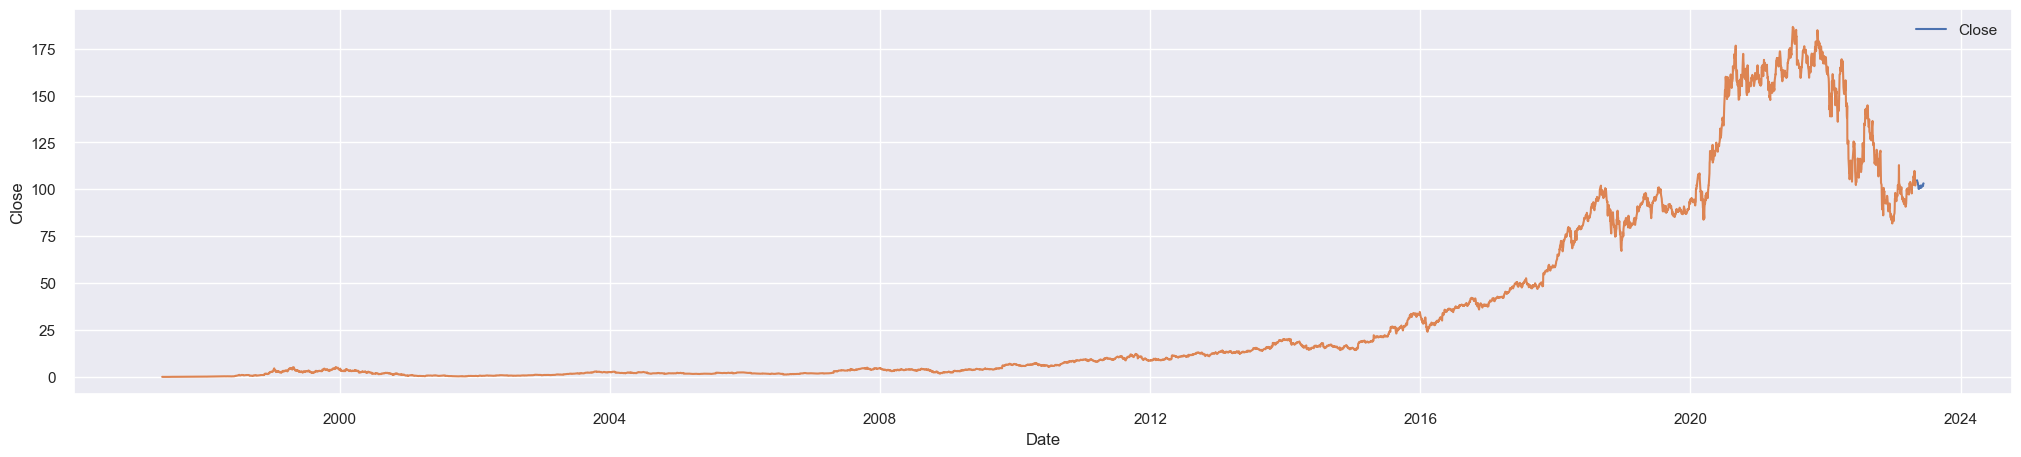

In [30]:
fig, ax = plt.subplots(figsize=(25,5))
sns.lineplot(forecast)
sns.lineplot(y = data['Close'], x = data['Date'])
plt.show()